In this project, we'll build a simple convolutional neural network for CIFAR-10 image classification. Code contained in this project was based on Tensorflow 1.2.1 and python 3.5. 

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
import time
from tqdm import tqdm
import tarfile
import tensorflow as tf

cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 6:
Image - Min Value: 7 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


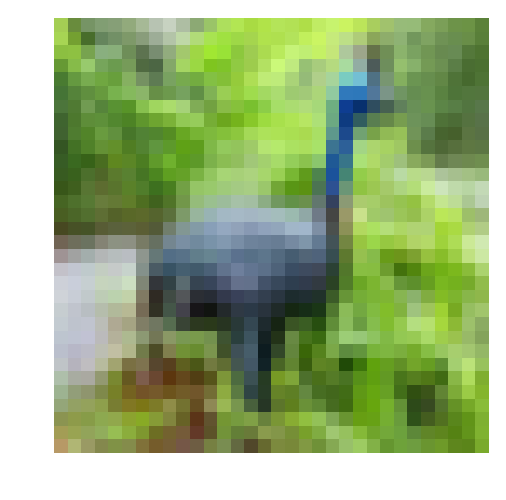

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 6
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

# Preprocess Data


## One hot encode

In [3]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    output = np.zeros([len(x), 10])
    for idx, item in enumerate(x):
        output[idx, item] = 1
    return output

This above function is equivalent to tf.one_hot(x, 10), but tensorflow module can not be pickled so we're sticking with the above implementation.

## Preprocess Data
We will randomly shuffle the data, normalize them and save them in binary format.

In [4]:
import tensorflow as tf
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, one_hot_encode)

# Checkpoint
The above work is all saved so when we're revisiting this notebook we don't have to do those work again. We can start from here.

In [5]:
import pickle
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
valid_features = np.transpose(valid_features,(0, 3, 1, 2))
batch_mean = np.mean(valid_features)
batch_std = np.std(valid_features)
valid_features = valid_features.astype(np.float32)
for ii in range(valid_features.shape[0]):
    valid_features[ii, :, :, :] = (valid_features[ii, :, :, :] - batch_mean) / batch_std


# Building the network

## Defining input

In [6]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    """
    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    """
    return tf.placeholder(tf.float32, [None, n_classes], "y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    """
    return tf.placeholder(tf.float32, None, "keep_prob")

## Convolution and maxpool layer

In [7]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    w = tf.get_variable("w", shape=[conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[1], conv_num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([conv_num_outputs], mean=0.0, stddev=0.1, dtype=tf.float32))
    
    wc = tf.nn.conv2d(x_tensor, w, strides=[1, 1, conv_strides[0], conv_strides[1]], padding='SAME', data_format="NCHW")
    z = tf.nn.bias_add(wc, b, data_format="NCHW")
    print(x_tensor.get_shape().as_list())
    return tf.nn.relu(z)


## Flatten layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size). Shortcut option: you can use classes from the TensorFlow Layers or TensorFlow Layers (contrib) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [8]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # reference : https://github.com/tensorflow/tensorflow/issues/7253
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], np.prod(x_tensor.get_shape().as_list()[1:])])
    
    # This also works
    #return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape[1:]).value])

## Fully connected layer

In [9]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    fc = tf.reshape(x_tensor, [-1, np.prod(x_tensor.get_shape().as_list()[1:])])
    
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    z = tf.add(tf.matmul(fc, w), b)
    
    return tf.nn.relu(z)

## Output layer

In [10]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    return tf.add(tf.matmul(x_tensor, w), b)


## Create the convolutional neural network model

In [11]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Convolution and maxpooling layers
    with tf.variable_scope("conv1"):
        conv1 = conv2d(x, 40, (3, 3), (1, 1))
        
    with tf.variable_scope("conv2"):
        conv2 = conv2d(conv1, 80, (3, 3), (1, 1))
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format="NCHW")
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    with tf.variable_scope("conv3"):
        conv3 = conv2d(conv2, 160, (3, 3), (1, 1))
    
    with tf.variable_scope("conv4"):
        conv4 = conv2d(conv3, 320, (3, 3), (1, 1))
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format="NCHW")
    conv4 = tf.nn.dropout(conv4, keep_prob)
    
    # Flatten Layer
    f = flatten(conv4)

    # Fully Connected layers
    with tf.variable_scope("fc1"):
        fc1 = fully_conn(f, 512)
        fc1 = tf.nn.dropout(fc1, keep_prob)
    with tf.variable_scope("fc2"):
        fc2 = fully_conn(fc1, 256)
        fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Output Layer
    with tf.variable_scope("out"):
        o = output(fc2, 10)
    
    # TODO: return output
    return o

## Build the network

In [12]:
tf.reset_default_graph()

# Inputs
# Channel first data format has hugh performance advantage!
# It's at least three times faster than channel last format.
x = neural_net_image_input((3, 32, 32))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(epsilon=1e-04).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

[None, 3, 32, 32]
[None, 40, 32, 32]
[None, 80, 16, 16]
[None, 160, 16, 16]


## Train network

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    """
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})

## Print Stats
It's important to evaluate the performance of model once in a while. If effect, we're feeding a small batch of data to the neural network through forward propagation and then caculate the accuracy of prediction. We don't want to do this too often as this slows down the overall process. It's important to keep in mind that since we're actually using the model for prediction but not training it, we need to set keep probability for dropout to 1 so we're not losing any connection between neurons. 

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

## Hyperparameters

In [15]:
epochs = 30
batch_size = 128
keep_probability = 0.5

## Train on a single CIFAR-10 batch

In [17]:
t1 = time.time()
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            batch_mean = np.mean(batch_features)
            batch_std = np.std(batch_features)
            batch_features = batch_features.astype(np.float32)
            for ii in range(batch_features.shape[0]):
                batch_features[ii, :, :, :] = (batch_features[ii, :, :, :] - batch_mean) / batch_std 
            batch_features = np.transpose(batch_features, (0, 3, 1, 2))
            start = time.time()
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            end = time.time()
            print('training one batch took: {:0.4f} seconds'.format(end-start))
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)
t2 = time.time()
print('total took:{:0.4f} seconds'.format(t2-t1))

Checking the Training on a Single Batch...
training one batch took: 0.7834 seconds
training one batch took: 0.0265 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0258 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0249 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0287 seconds
training one batch took: 0.0264 seconds
training one batch took: 0.0261 seconds
training one batch took: 0.0249 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0303 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0250 seconds
training one batch took: 0.0309 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0249 secon

training one batch took: 0.0298 seconds
training one batch took: 0.0333 seconds
training one batch took: 0.0259 seconds
training one batch took: 0.0245 seconds
training one batch took: 0.0245 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0280 seconds
training one batch took: 0.0285 seconds
training one batch took: 0.0142 seconds
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.3420 Validation Accuracy: 0.458800
training one batch took: 0.0292 seconds
training one batch took: 0.0292 seconds
training one batch took: 0.0269 seconds
training one batch took: 0.0268 seconds
training one batch took: 0.0263 seconds
training one batch took: 0.0265 seconds
training one batch took: 0.0282 seconds
training one batch took: 0.0240 seconds
training one batch took: 0.0239 seconds
training one batch took: 0.0242 seconds
training one batch took: 0.0241 seconds
training one batch took: 0.0267 seconds
training one batch took: 0.0246 seconds
trai

training one batch took: 0.0287 seconds
training one batch took: 0.0278 seconds
training one batch took: 0.0247 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0250 seconds
training one batch took: 0.0264 seconds
training one batch took: 0.0276 seconds
training one batch took: 0.0286 seconds
training one batch took: 0.0263 seconds
training one batch took: 0.0309 seconds
training one batch took: 0.0276 seconds
training one batch took: 0.0279 seconds
training one batch took: 0.0267 seconds
training one batch took: 0.0270 seconds
training one batch took: 0.0306 seconds
training one batch took: 0.0272 seconds
training one batch took: 0.0265 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0274 seconds
training one batch took: 0.0113 seconds
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.0152 Validation Accuracy: 0.557800
training one batch took: 0.0267 seconds
training one batch took: 0.0261 seconds
trai

training one batch took: 0.0250 seconds
training one batch took: 0.0306 seconds
training one batch took: 0.0272 seconds
training one batch took: 0.0278 seconds
training one batch took: 0.0248 seconds
training one batch took: 0.0248 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0278 seconds
training one batch took: 0.0249 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0259 seconds
training one batch took: 0.0275 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0265 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0270 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0268 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0247 seconds


training one batch took: 0.0257 seconds
training one batch took: 0.0261 seconds
training one batch took: 0.0258 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0278 seconds
training one batch took: 0.0272 seconds
training one batch took: 0.0268 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0277 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0290 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0277 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0258 seconds


training one batch took: 0.0248 seconds
training one batch took: 0.0290 seconds
training one batch took: 0.0277 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0274 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0265 seconds
training one batch took: 0.0269 seconds
training one batch took: 0.0258 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0283 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0276 seconds
training one batch took: 0.0276 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0258 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0270 seconds


training one batch took: 0.0255 seconds
training one batch took: 0.0266 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0246 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0250 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0268 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0259 seconds
training one batch took: 0.0258 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0266 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0259 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0278 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0262 seconds


training one batch took: 0.0271 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0116 seconds
Epoch 20, CIFAR-10 Batch 1:  Loss:     0.0778 Validation Accuracy: 0.705000
training one batch took: 0.0271 seconds
training one batch took: 0.0276 seconds
training one batch took: 0.0265 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0267 seconds
training one batch took: 0.0261 seconds
training one batch took: 0.0262 seconds
training one batch took: 0.0271 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0266 seconds
training one batch took: 0.0272 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0250 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0252 seconds
trai

training one batch took: 0.0255 seconds
training one batch took: 0.0275 seconds
training one batch took: 0.0267 seconds
training one batch took: 0.0259 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0280 seconds
training one batch took: 0.0249 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0267 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0250 seconds
training one batch took: 0.0259 seconds
training one batch took: 0.0297 seconds
training one batch took: 0.0262 seconds
training one batch took: 0.0268 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0115 seconds
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.1126 Validation Accuracy: 0.706600
training one batch took: 0.0270 seconds
training one batch took: 0.0272 seconds
training one batch took: 0.0271 seconds
training one batch took: 0.0251 seconds
trai

training one batch took: 0.0255 seconds
training one batch took: 0.0289 seconds
training one batch took: 0.0267 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0264 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0267 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0252 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0278 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0266 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0251 seconds
training one batch took: 0.0258 seconds
training one batch took: 0.0269 seconds
training one batch took: 0.0253 seconds
training one batch took: 0.0258 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0249 seconds
training one batch took: 0.0258 seconds


training one batch took: 0.0262 seconds
training one batch took: 0.0273 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0260 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0257 seconds
training one batch took: 0.0255 seconds
training one batch took: 0.0264 seconds
training one batch took: 0.0273 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0277 seconds
training one batch took: 0.0300 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0287 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0284 seconds
training one batch took: 0.0262 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0259 seconds
training one batch took: 0.0254 seconds
training one batch took: 0.0264 seconds
training one batch took: 0.0256 seconds
training one batch took: 0.0255 seconds


## Fully train the model

In [ ]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                
                batch_mean = np.mean(batch_features)
                batch_std = np.std(batch_features)
                batch_features = batch_features.astype(np.float32)
                for ii in range(batch_features.shape[0]):
                    batch_features[ii, :, :, :] = (batch_features[ii, :, :, :] - batch_mean) / batch_std 
                batch_features = np.transpose(batch_features, (0, 3, 1, 2))
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

## Test model

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

batch_size = 128

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    test_features = test_features.astype(np.float32)
    batch_mean = np.mean(test_features)
    batch_std = np.std(test_features)
    for ii in range(test_features.shape[0]):
        test_features[ii,:,:,:] = (test_features[ii,:,:,:] - batch_mean) / batch_std
    
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_feature_batch = np.transpose(test_feature_batch, (0, 3, 1, 2))
            test_batch_acc_total += sess.run(loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_features = np.transpose(random_test_features, (0, 3, 1, 2))
        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        random_test_features = np.transpose(random_test_features, (0, 2, 3, 1))
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()